# Dense Retrieval for hep-th arXiv

The high-energy theoretical physics (hep-th) literature is exceptionally dense. Papers are packed with highly specialized terminology, domain-specific conventions and abbreviations, as well as long chains of tightly coupled ideas, often extending far beyond the brief summary given by the abstract. As a result, search approaches that rely primarily on titles, abstracts, or keyword matching have significant limitations: they often miss relevant work entirely, or find papers whose abstract appears related but whose substantive content is not.

This problem becomes especially acute when the goal is not merely to identify relevant papers, but to locate where within those papers a given concept, construction, or argument is discussed. In hep-th, crucial ideas are frequently introduced deep inside a section, developed across several paragraphs, and never explicitly restated in the abstract. A search system that cannot look beyond abstracts is therefore fundamentally constrained.

The goal of this project is to build a semantic search engine for the hep-th arXiv that enables fast, meaning-aware search over the full text of papers, returning not only the most relevant papers but the specific sections or passages that best match a given query. Rather than treating each paper as a single unit, the system operates at the level of text chunks, which allows for fine-grained retrieval of relevant content.

To this end, we constructed a large-scale corpus spanning five years of hep-th submissions, from 2021 to 2025, including cross-listed papers and totaling over 36,000 documents. Each paper was carefully processed to remove mathematical expressions and LaTeX artifacts that are not useful for semantic retrieval, such as equations, citations, references, figures, code blocks, and custom macros. The result is a cleaned textual representation that preserves the conceptual structure of the papers while eliminating noise.

The processed corpus, comprising approximately 1.6 GB of cleaned text, was divided into text segments, for a total of roughly 850,000 chunks. A custom word-level vocabulary of approximately 43,000 tokens was built from this corpus, and each chunk was encoded accordingly. Using this representation, a transformer-based encoder model was trained to map text chunks into a dense vector space. Given a natural-language prompt, the model produces an embedding that can be rapidly compared against the corpus to identify the most semantically relevant chunks.

The end result is a system capable of scanning a large body of highly technical literature and locating precise, contextually relevant sections within papers, rather than relying on coarse metadata or shallow keyword matches. This notebook documents the construction, training, and evaluation of that retrieval component, which can serve as the foundation for more advanced retrieval-augmented projects in the future.

This project was completed on a 32 GB Mac M1 system.

In [1]:
import sys
import os

from torch.utils.data import Dataset

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import scraper, model

## Data extraction and processing

In this section, we describe the data extraction and processing pipeline implemented in the `src/scraper.py` module. The project includes a pre-trained model in the `model` folder, but to test its performance a corpus of text chunks must be available in the `data` directory. The corpus used to train this model can be downloaded from Hugging Face:

https://huggingface.co/datasets/AlexanderGTumanov/hep-th-rag

Create a `data` directory in the project root and place the `corpus` folder inside it, as many functions expect this as the default location. Alternatively, the corpus (or a different version covering another date range) can be built from scratch using the functions provided in the `scraper.py` module. The dataset used to train this model was collected using the `scrape_arxiv_sources` command with the arguments listed below. Note that due to arXiv API limitations, scraping a dataset of this size requires approximately one day of runtime. The extracted raw data is stored in the `data/raw` directory, while the metadata file is saved in the root of the `data` folder. It can be loaded using `load_metadata(metadata_path = "../data/metadata.jsonl")`.

In [ ]:
start = '2021-01-01'
end = '2025-12-31'
category = "hep-th"
include_crosslists = True
data_dir = "../data"

scraper.scrape_arxiv_sources(start, end, category = category, include_crosslists = include_crosslists, data_dir = data_dir)

While in principle the pretrained model can be applied to papers from categories other than hep-th, its performance is not expected to be high, since it was trained exclusively on papers in this category and those cross-listed to it. A new model, however, can be trained for different arXiv categories using the tools presented in the next section.

The processing pipeline works as follows. First, the main source file is identified via the `\begin{document}` marker. If the paper is split across multiple files using `\input` or `\include`, those files are loaded and merged. Second, all custom macros defined by the authors are extracted. Their definitions are then removed, and macro invocations are expanded in place. Third, the paper is split into sections or chapters. Overly technical components such as appendices, bibliographies, and acknowledgements are removed. Abstracts are also discarded, as otherwise abstract-level chunks would dominate the training process. Papers that do not use `\begin{section}` or `\begin{chapter}` are processed as a single block.

The cleanup phase then begins. All math environments are removed and replaced with the placeholders `MATH`, `EQN`, and `NUM`. Other special environments are replaced with corresponding placeholders (`CITE`, `REF`, `FIG`, `URL`, `CODE`, `ALG`) to preserve grammatical structure after cleanup. Non-math structural environments such as `\begin{theorem}` or `\begin{itemize}` are removed, with their contents merged into the main body. All remaining special commands, comments, and formatting directives are stripped, punctuation is standardized, and the text is finally Latinized and lowercased.

The hep-th community is notorious for its excessive (and often times somewhat perverse) use of LaTeX macros. In some cases, macro systems are too complex to be algorithmically resolved with reasonable effort. Papers with leftover LaTeX artifacts or math symbols are discarded. Such papers account for under 3% of all publications. The `skip_threshold` parameter controls the tolerance for these remaining artifacts.

The processed data is stored in `data/processed`, together with a `skipped.jsonl` file listing the IDs of skipped articles.

In [3]:
scraper.process_sources(data_dir = "../data", skip_threshold = 0)

                              
total papers processed: 37541
successfully processed: 36451 (97.1 %)
skipped: 1090 (2.9 %)


Several additional preprocessing steps were introduced to better suit the structure of hep-th papers. In particular, the model replaces all numbers and alphanumeric combinations with the placeholder token `NUM`. The main exceptions are small integers from 0 to 11, as well as 26, common group-theoretical and geometric notations such as `so6`, `psu2`, `E8`, `AdS5`, and similar forms, and dimension labels like `4D`, `11D`, or `26D`. This filters out many processing artifacts, grant numbers, unprocessed citation labels, and other irrelevant or overly specific tokens, while preserving the core symbolic conventions that frequently appear in high-energy physics literature.

The `build_corpus` function splits each paper section into uniform-length text chunks. The `chunk_size` parameter controls the length of each chunk in characters, while `overlap` specifies a small overlap between neighboring chunks. The resulting corpus file is written to the `data/corpus` directory. Chunks with an excessive number of placeholders (`MATH`, `EQN`, `CITE`, etc.) are treated as overly technical and discarded; the `placeholder_threshold` parameter sets the maximum allowed placeholder rate. The `min_tokens` parameter is used to discard very short chunks, which are often pathological.

In [4]:
scraper.build_corpus(chunk_size = 1700, overlap = 50, placeholder_threshold = 0.15, min_tokens = 32)


total number of chunks: 884159
chunks added to corpus: 859664 (97.23 %)
chunks discarded: 24495 (2.77 %)


The model uses word-level tokenization. The `estimate_sequence_length` function determines a suitable sequence length for the neural network, measured in tokens, as the smallest value that covers the chosen percentile of chunk lengths specified by the `percentile` parameter. If `multiple_of` is not `None`, the result is rounded up to the nearest multiple of that value; in practice, sequence lengths are often chosen as multiples of 32.

The model can be trained with a `seq_len` smaller than the suggested value, which can significantly speed up training. This allows the model to learn token attention on shorter contexts first. Once this stage is complete, an additional context-extension epoch can be run at the sequence length that will be used for retrieval. This provides a small performance improvement, but for setups without positional encoding it is generally optional.

Chunk embeddings are computed after training at the suggested `seq_len` to avoid discarding meaningful data. Increasing `seq_len` beyond this value, either during training or retrieval, does not provide significant benefits.

In [5]:
seq_len_optimal = scraper.estimate_sequence_length(corpus_dir = "../data/corpus", percentile = 0.95, multiple_of = 32)

suggested sequence length: 320


## Model training

The vocabulary of the model can be built using the `build_vocab` function. It scans the corpus for all distinct words and orders them by usage frequency. The tail of this list is largely uninformative, consisting of typos, obscure vocabulary, rarely used terms, abbreviations, and names. To optimize the training process, the vocabulary must be truncated. This can be done either by capping the total number of tokens with the `max_vocab` argument or by setting a minimum frequency threshold with `min_freq`. The vocabulary used to train this model was generated using

In [ ]:
vocab = model.build_vocab(model.iterate_chunks(), min_freq = 10, max_vocab = None, vocab_path = "../model/vocab.jsonl")

Special tokens `<unk>` and `<pad>` are used to represent out-of-vocabulary words and to pad sequences that are shorter than the chosen context length. Padding tokens are masked out in the attention mechanism, and both `<unk>` and `<pad>` tokens are excluded from the pooling step, so they do not influence the final embedding.

This vocabulary is saved in the model directory and can be loaded using the following command.

In [2]:
vocab = model.load_vocab(vocab_path = "../model/vocab.jsonl")

print("vocab size:", len(vocab.id_to_token))
print("first 15 tokens:", vocab.id_to_token[:15])
print("last 15 tokens:", vocab.id_to_token[-15:])

vocab size: 43258
first 15 tokens: ['<pad>', '<unk>', 'the', ',', '.', 'MATH', 'of', 'in', 'to', 'is', 'a', '-', 'and', 'we', 'for']
last 15 tokens: ['yours', 'yugoslavia', 'yves', 'zanusso', 'zbpd', 'zeca', 'zeitgeist', 'zeldovic', 'zeptosecond', 'zeroed', 'zgnrs', 'zipfs', 'zipping', 'zns', 'zubair']


Next, the dataset is split into training and validation sets, encoded, and wrapped into data loaders. Although the corpus construction suggests a sequence length of 320 tokens, most of the training loop (3 epochs) for the pretrained model was carried out with `seq_len = 160`. Using a shorter sequence length makes it feasible to train the model for multiple epochs on the available hardware, whereas longer sequences would lead to excessively long training times per epoch.

To prepare the model for retrieval, the training loop then runs for one additional epoch at `seq_len = 320` to adapt the model to the longer sequence length used during inference.

In [ ]:
train_loader, valid_loader = model.prepare_dataloaders(vocab, seq_len = 160, batch_size = 128, valid_split = 0.2, seed = 42, corpus_dir = "../data/corpus")

This function prefilters chunks with a high number of `<unk>` tokens. The tolerance of this filter is controlled by two keyword arguments, with default values `unk_discard_ratio = 0.5` and `pad_threshold_ratio = 0.7`.

The model is a Transformer-based encoder that maps token sequences to fixed-size dense embeddings. It uses a 256-dimensional token representation, four Transformer layers with eight attention heads each, and feed-forward blocks of size 640, with dropout set to 0.1. The encoder supports sequences of up to 256 tokens and produces a 256-dimensional output embedding. Positional encoding is optional and was disabled during training, as it is not strictly required for retrieval tasks. As a result, the model is agnostic to `seq_len`: although it was trained with `seq_len = 160`, it can handle other reasonable sequence lengths. A fresh model can be initialized using:

In [5]:
encoder = model.ChunkEncoder(
    vocab_size = len(vocab.token_to_id),
    d_model = 256,
    n_heads = 8,
    n_layers = 4,
    d_ff = 640,
    max_len = 256,
    dropout = 0.1,
    out_dim = 256,
    use_positional_encoding = False,
)

A pre-existing model can be loaded in using:

In [ ]:
encoder = model.load_model(model_path = "../model/model.pt")

At `seq_len = 160`, the model parameters were chosen to yield an approximate training time of 15 hours per epoch on a 32 GB Mac M1 system, which was used for this project. Although the model can be trained for multiple epochs in a single run, it is recommended to run epochs sequentially. After each epoch, a new subdirectory is created in the model directory, containing the model checkpoint along with the per-batch training and validation loss history for that epoch. To resume training from a previously trained checkpoint, use the `load_model` function to load the model from disk.

The model is trained using an InfoNCE / NT-Xent–style contrastive objective in a dual-encoder setup. For each batch, the same input sequences are encoded twice, with dropout introducing stochastic variation between the two views. Similarity scores are computed using scaled dot products and divided by a temperature parameter `tau`, which controls the sharpness of the similarity distribution. The contrastive loss encourages each sequence to be most similar to its own counterpart while all other sequences in the batch serve as negatives. This setup, while more computationally demanding, prevents the representation collapse that commonly occurs in single-encoder models trained without an explicit contrastive objective.

In [ ]:
encoder = model.train_model(encoder, train_loader, valid_loader, epochs = 1, batches = 0, start_batch = 0, max_grad_norm = 1, clip_start_batch = 15)

The `train_model` function also supports partial epochs. When the `batches` parameter is specified, the model processes the given number of batches from the next epoch after completing the final full epoch of training. The `start_batch` parameter specifies the starting batch within that additional epoch.

The pretrained model was trained for three epochs at `seq_len = 160` and an additional half epoch at `seq_len = 320`. Below is the plot of the per-batch training and validation loss histories over the course of training, shown on a log scale.

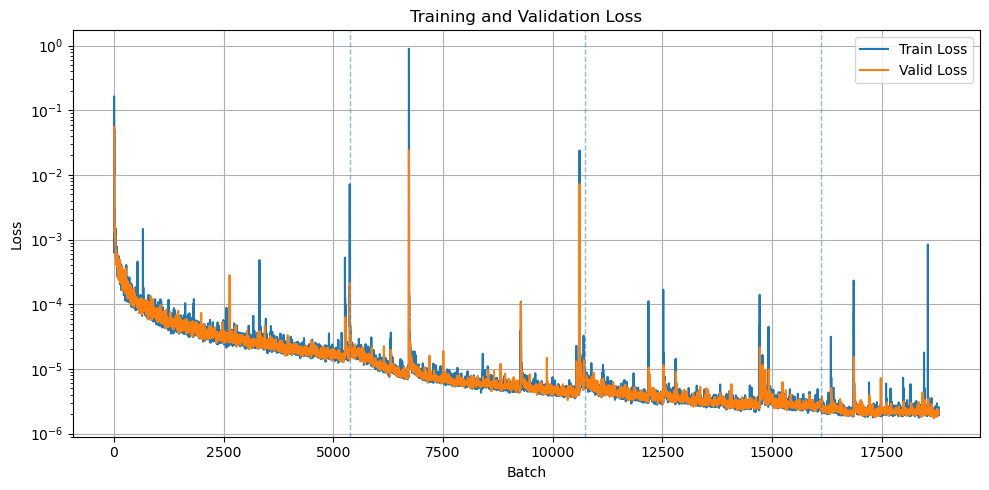

In [18]:
history = model.load_history('../model/history.pt')
model.plot_history(history, log_x = False, log_y = True, batches_per_epoch = 5372)

## Chunk embeddings

To use the model effectively, the chunks first need to be encoded into fixed-length vector representations. These embeddings are then stored and used during retrieval to compare queries against the corpus. First, we load the model using:

In [2]:
encoder = model.load_model(model_path = "../model/model.pt")
vocab = model.load_vocab(vocab_path = "../model/vocab.jsonl")

Embedding dataloaders are built at the full sequence length of 320 tokens and do not use cropping or `<unk>`-based prefiltering. This ensures that as much data as possible is used for decoding.

In [4]:
loader = model.prepare_embedding_dataloader(vocab, seq_len = 320, batch_size = 128, corpus_dir = "../data/corpus")

The `build_chunk_embeddings` computes the embeddings, saves it to `chunk_embeddings.pt`, and writes the list of the corresponding chunk IDs to `chunk_ids.json` in the corpus directory.

In [ ]:
model.build_chunk_embeddings(encoder, loader, corpus_dir = "../data/corpus")

## Retrieval Tests

The core functionality of this model is the ability to retrieve semantically relevant chunks based on a user prompt. However, applying this retrieval method directly to the full corpus is inefficient, since most papers can be filtered out as irrelevant using much faster techniques. One such technique is TF–IDF lexical similarity search, which is extremely fast and can quickly narrow the corpus down to a set of lexically relevant chunks. At that stage, the encoder neural network can be used to rerank these candidates based on deeper semantic context.

In [2]:
encoder = model.load_model(model_path = "../model/model.pt")
vocab = model.load_vocab(vocab_path = "../model/vocab.jsonl")

Below, we perform a series of tests of the pretrained model on various prompts and demonstrate the most effective reranking strategies.

### Prompt 1: Form Factor Operator Product Expansion

The first prompt is intentionally designed to use relatively broad terminology within the context of high energy physics, while still being highly specific in a broader setting. In particular, it is meant to retrieve the following set of papers written by the author of this project and collaborators between 2021 and 2025:

- **2308.08432:** *Wilson Loop Duality and OPE for Super Form Factors of Half-BPS Operators* by Benjamin Basso, Alexander G. Tumanov
- **2209.06816:** *Analytic Four-Point Lightlike Form Factors and OPE of Null-Wrapped Polygons* by Yuanhong Guo, Lei Wang, Gang Yang
- **2112.10569:** *An Operator Product Expansion for Form Factors III. Finite Coupling and Multi-Particle Contributions* by Amit Sever, Alexander G. Tumanov, Matthias Wilhelm
- **2105.13367:** *An Operator Product Expansion for Form Factors II. Born level* by Amit Sever, Alexander G. Tumanov, Matthias Wilhelm

The prompt and the corresponding selection of papers are:

In [8]:
prompt = "Finite-coupling exact results for N = 4 SYM form factors of local operators as expansions around the collinear limits of null-polygons obtained through the use of integrability methods."
selection = ["2308.08432", "2209.06816", "2112.10569", "2105.13367"]

The `top_lexical_chunks` function retrieves the top 5000 lexically matching chunks from the corpus and orders them by their TF–IDF similarity scores. The `aggregate_to_papers` function can then optionally be used to convert chunk-level scores into paper-level scores. Three optional arguments, `pool_level`, `top_k_chunks`, and `top_k_sections`, control this aggregation step. The `pool_level` argument determines whether aggregation happens at the paper level directly, or whether chunks are first pooled into section scores and then pooled across sections. The other two arguments control whether the score is averaged over several top hits or taken from a single best-matching chunk. By default, the function uses the best chunk score per paper.

For the context length of 320 used in this project, taking the best chunk score per paper tends to work well, since individual chunks are usually long enough to contain the semantic context needed to judge relevance. For shorter context lengths, chunk scores are typically noisier and aggregation over multiple chunks or sections may become more important.

After computing the ranking, we check where the four selected papers land.

In [4]:
tfidf_chunks = model.top_lexical_chunks(prompt, lexical_candidates = 5000, corpus_dir = "../data/corpus")
tfidf_papers = model.aggregate_to_papers(tfidf_chunks, pool_level = "section", top_k_chunks = 1, top_k_sections = 1, corpus_dir = "../data/corpus")

print('Paper rankings before dense reranking:')
model.find_paper(tfidf_papers, selection, corpus_dir = "../data/corpus")

Paper rankings before dense reranking:
2308.08432: present, rank =  247, score =  0.233014
2209.06816: present, rank = 1542, score =  0.169453
2112.10569: present, rank =    3, score =  0.361611
2105.13367: present, rank = 1619, score =  0.167905


One of the papers, `2112.10569`, appears near the top at rank 3. This indicates a strong lexical match and substantial vocabulary overlap with the prompt. Another paper, `2308.08432`, lands in the middle of the ranking, while the remaining two papers are not highlighted by the lexical similarity search at all. The next step is to apply dense reranking to all 5000 retrieved chunks. We use the `dense_rerank` function with `method = "dense"`, which replaces the lexical scores entirely with neural similarity scores. This yields:

In [5]:
dense_chunks = model.dense_rerank(tfidf_chunks, prompt, encoder, vocab, seq_len = 320, method = "dense", corpus_dir = "../data/corpus")
dense_papers = model.aggregate_to_papers(dense_chunks, pool_level = "section", top_k_chunks = 1, top_k_sections = 1, corpus_dir = "../data/corpus")

print('Paper rankings after dense reranking:')
model.find_paper(dense_papers, selection, corpus_dir = "../data/corpus")

Paper rankings after dense reranking:
2308.08432: present, rank =    1, score =  0.410493
2209.06816: present, rank = 1003, score =  0.099015
2112.10569: present, rank =  415, score =  0.176434
2105.13367: present, rank =  258, score =  0.203030


This produced several clear improvements. Paper `2308.08432` moved up to rank 1, while `2209.06816` and `2105.13367` both gained significant ground. The problem is that `2112.10569` dropped noticeably in the ranking. This behavior is typical for dense retrievers. Neural encoders capture broader semantic context, but they do not always preserve the exact lexical signals that place some papers correctly near the top. As a result, semantically relevant papers that were previously ranked low may move up, while papers that already matched the query well can be pushed down.

To address this issue, several strategies can be used. They all follow the same basic principle: when the lexical rank is high, it should dominate, and dense scores should have little or no effect. As we move further down the list, the influence of dense scores should gradually increase, until they become the primary signal.

The first and simplest approach is to pin the top k chunks in their original lexical order and apply dense reranking only to the remainder. This is done using the `dense_rerank` function with `method = "pin_top"` and `k_pinned = 10`. The resulting ranking is:

In [6]:
pin_chunks = model.dense_rerank(tfidf_chunks, prompt, encoder, vocab, seq_len = 320, method = "pin_top", k_pinned = 10, corpus_dir = "../data/corpus")
pin_papers = model.aggregate_to_papers(pin_chunks, pool_level = "section", top_k_chunks = 1, top_k_sections = 1, corpus_dir = "../data/corpus")

print('Paper rankings after pinning:')
model.find_paper(pin_papers, selection, corpus_dir = "../data/corpus")

Paper rankings after pinning:
2308.08432: present, rank =   12, score =  0.330813
2209.06816: present, rank = 1004, score =  0.099015
2112.10569: present, rank =    3, score =  0.361611
2105.13367: present, rank =  264, score =  0.203030


This approach works very well in practice, but it has an important drawback. Paper `2308.08432` is effectively locked out of the top positions. The neural model identifies it as the best semantic match, but it cannot move it to the top because those positions are reserved for lexically strong papers. This makes the method somewhat rigid and motivates more symmetric approaches.

One such approach is score fusion. Instead of strictly separating the lexical and dense parts of the ranking, both scores are combined into a single value. For each chunk, the final score is computed as

$$
\text{score} = (1 - \alpha)\,\text{dense\_score} + \alpha\,\text{tfidf\_score}
$$

The parameter `alpha` controls the balance between the two signals. When `alpha` is close to 1, the ranking is mostly lexical. When `alpha` is close to 0, the ranking is dominated by dense similarity. Intermediate values produce a smooth interpolation between the two. This method can be applied using the `dense_rerank` function with `method = "score_fusion"` and `alpha = 0.5`:

In [16]:
fusion_chunks = model.dense_rerank(tfidf_chunks, prompt, encoder, vocab, seq_len = 320, method = "score_fusion", alpha = 0.5, corpus_dir = "../data/corpus")
fusion_papers = model.aggregate_to_papers(fusion_chunks, pool_level = "section", top_k_chunks = 1, top_k_sections = 1, corpus_dir = "../data/corpus")

print('Paper rankings after Reciprocal Rank Fusion:')
model.find_paper(fusion_papers, selection, corpus_dir = "../data/corpus")

Paper rankings after Reciprocal Rank Fusion:
2308.08432: present, rank =    4, score =  0.313321
2209.06816: present, rank = 1107, score =  0.134234
2112.10569: present, rank =   15, score =  0.269023
2105.13367: present, rank =  391, score =  0.185467


This method has its merits, but it is rarely the best option overall. A much stronger alternative is Reciprocal Rank Fusion (RRF). Instead of combining raw scores, RRF combines the ranks assigned by the lexical and dense systems. For each chunk, the final score is computed as

$$
\text{score} = \frac{1}{k + r_{\text{tfidf}}} + \frac{1}{k + r_{\text{dense}}}
$$

where \( r_{\text{tfidf}} \) and \( r_{\text{dense}} \) are the ranks of the chunk in the TF–IDF and dense lists, respectively, and \( k \) is a constant that controls how quickly the contribution of lower ranks decays. We obtain this ranking by running `dense_rerank` with `method = "rrf"` and `k_rrf = 10`:

In [49]:
rrf_chunks = model.dense_rerank(tfidf_chunks, prompt, encoder, vocab, seq_len = 320, method = "rrf", k_rrf = 10, corpus_dir = "../data/corpus")
rrf_papers = model.aggregate_to_papers(rrf_chunks, pool_level = "section", top_k_chunks = 1, top_k_sections = 1, corpus_dir = "../data/corpus")

print('Paper rankings after Reciprocal Rank Fusion:')
model.find_paper(rrf_papers, selection, corpus_dir = "../data/corpus")

Paper rankings after Reciprocal Rank Fusion:
2308.08432: present, rank =    1, score =  0.092281
2209.06816: present, rank = 1346, score =  0.000848
2112.10569: present, rank =    7, score =  0.078677
2105.13367: present, rank =  438, score =  0.003125


This keeps papers with both strong semantic and strong lexical signals near the top, while still providing modest improvements for other relevant papers. The final results can be displayed using the `print_matches` function:

In [54]:
model.print_matches(rrf_papers, top_k = 3, max_sections = 3, corpus_dir = "../data/corpus")

1. doc_score = 0.092281
    title   : Wilson Loop Duality and OPE for Super Form Factors of Half-BPS Operators
    authors : Benjamin Basso, Alexander G. Tumanov
    doc_id  : 2308.08432
    sections:
      1. Super form factors and Wilson loops      score = 0.092281
      2. Introduction                             score = 0.041962
      3. Form factor OPE                          score = 0.002528

2. doc_score = 0.091708
    title   : String theory methods for defect CFTs
    authors : Georgios Linardopoulos
    doc_id  : 2501.11985
    sections:
      1. Holographic defect correlators \label{Section:HolographicDefectCorrelators}                            score = 0.091708
      2. Introduction and motivation \label{Section:IntroductionMotivation}                                     score = 0.001758
      3. String integrability of holographic defects \label{Section:StringIntegrabilityHolographicDefects}      score = 0.001108

3. doc_score = 0.087500
    title   : Anomalous dimension

### Prompt 2: Form factor perturbative bootstrap

For the second prompt, we demonstrate how dense reranking can help push down false positives—papers that share some lexical overlap with the prompt but primarily focus on related yet different topics.

As an example, consider the perturbative bootstrap program, for which the Form Factor OPE discussed in the first prompt serves as a conceptual foundation. It is therefore not surprising that the FFOPE papers devote significant space to describing the perturbative bootstrap program, especially in the introduction and conclusion sections, even though they do not perform such calculations directly.

We will therefore treat two papers from prompt 1 as false positives in this context:

- **2112.10569:** *An Operator Product Expansion for Form Factors III. Finite Coupling and Multi-Particle Contributions* by Amit Sever, Alexander G. Tumanov, Matthias Wilhelm
- **2105.13367:** *An Operator Product Expansion for Form Factors II. Born level* by Amit Sever, Alexander G. Tumanov, Matthias Wilhelm

For comparison, we use two papers that are strongly and directly relevant to the perturbative bootstrap as positive controls:

- **2410.22402:** *The three-point form factor of Tr \( \phi^3 \) to six loops* by Benjamin Basso, Lance J. Dixon, Alexander G. Tumanov
- **2204.11901:** *Bootstrapping a stress-tensor form factor through eight loops* by Lance J. Dixon, Omer Gurdogan, Andrew J. McLeod, Matthias Wilhelm

In [35]:
prompt = "Using the integrability-based Form Factor OPE (FFOPE) approch and cluster non-adjacency relations to bootstrap N = 4 SYM form factors at high loop orders."
positives = ["2410.22402", "2204.11901"]
negatives = ["2112.10569", "2105.13367"]

First, we retrieve the top 5000 chunks and determine the rankings of all four papers.

In [36]:
tfidf_chunks = model.top_lexical_chunks(prompt, lexical_candidates = 5000, corpus_dir = "../data/corpus")
tfidf_papers = model.aggregate_to_papers(tfidf_chunks, pool_level = "section", top_k_chunks = 1, top_k_sections = 1, corpus_dir = "../data/corpus")

print('Positives before reranking:')
model.find_paper(tfidf_papers, positives, corpus_dir = "../data/corpus")
print()
print('Negatives before reranking:')
model.find_paper(tfidf_papers, negatives, corpus_dir = "../data/corpus")

Positives before reranking:
2410.22402: present, rank =    1, score =  0.420640
2204.11901: present, rank =    5, score =  0.307528

Negatives before reranking:
2112.10569: present, rank =   20, score =  0.261950
2105.13367: present, rank =   24, score =  0.251529


Unsurprisingly, the positive examples score extremely highly due to their strong lexical similarity to the prompt. The negative examples, however, are not far behind, and they still rank above many papers that are more directly relevant. We can now apply dense reranking:

In [37]:
dense_chunks = model.dense_rerank(tfidf_chunks, prompt, encoder, vocab, seq_len = 320, method = "dense", corpus_dir = "../data/corpus")
dense_papers = model.aggregate_to_papers(dense_chunks, pool_level = "section", top_k_chunks = 1, top_k_sections = 1, corpus_dir = "../data/corpus")

print('Positives after dense reranking:')
model.find_paper(dense_papers, positives, corpus_dir = "../data/corpus")
print()
print('Negatives after dense reranking:')
model.find_paper(dense_papers, negatives, corpus_dir = "../data/corpus")

Positives after dense reranking:
2410.22402: present, rank =   32, score =  0.298613
2204.11901: present, rank =   45, score =  0.285171

Negatives after dense reranking:
2112.10569: present, rank =  486, score =  0.152153
2105.13367: present, rank =   65, score =  0.266375


As established earlier, pure dense reranking is rarely a good option. Although it produces the desired effect of pushing the false positives down, it also affects the true positives in the same way. This forces us to consider the composite ranking schemes described above. We begin with the pin-top method:

In [39]:
pin_chunks = model.dense_rerank(tfidf_chunks, prompt, encoder, vocab, seq_len = 320, method = "pin_top", k_pinned = 10, corpus_dir = "../data/corpus")
pin_papers = model.aggregate_to_papers(pin_chunks, pool_level = "section", top_k_chunks = 1, top_k_sections = 1, corpus_dir = "../data/corpus")

print('Positives after pin-top + dense reranking:')
model.find_paper(pin_papers, positives, corpus_dir = "../data/corpus")
print()
print('Negatives after pin-top + dense reranking:')
model.find_paper(pin_papers, negatives, corpus_dir = "../data/corpus")

Positives after pin-top + dense reranking:
2410.22402: present, rank =    1, score =  0.420640
2204.11901: present, rank =    5, score =  0.307528

Negatives after pin-top + dense reranking:
2112.10569: present, rank =  486, score =  0.152153
2105.13367: present, rank =   67, score =  0.266375


This produces the desired effect, but it is extremely sensitive to the choice of the pin cutoff. Adjusting this value directly determines which papers are preserved near the top and which are pushed down the ranking, making the method somewhat ad hoc rather than systematic.

In contrast, the RRF scheme provides a much more robust way to perform the reranking:

In [40]:
rrf_chunks = model.dense_rerank(tfidf_chunks, prompt, encoder, vocab, seq_len = 320, method = "rrf", k_rrf = 10, corpus_dir = "../data/corpus")
rrf_papers = model.aggregate_to_papers(rrf_chunks, pool_level = "section", top_k_chunks = 1, top_k_sections = 1, corpus_dir = "../data/corpus")

print('Paper rankings before dense reranking:')
model.find_paper(rrf_papers, positives, corpus_dir = "../data/corpus")

print('Paper rankings before dense reranking:')
model.find_paper(rrf_papers, negatives, corpus_dir = "../data/corpus")

Paper rankings before dense reranking:
2410.22402: present, rank =    3, score =  0.092559
2204.11901: present, rank =   10, score =  0.073529
Paper rankings before dense reranking:
2112.10569: present, rank =   43, score =  0.025095
2105.13367: present, rank =   36, score =  0.029509


It keeps the positive papers close to the top, while the negative ones are pushed slightly lower in the ranking.


# Conclusions

In this project we developed a domain-specific retrieval system for high energy theory papers that combines fast lexical filtering with neural semantic reranking. The work covered the full pipeline, from processing raw arXiv sources to training the encoder and evaluating hybrid ranking strategies.

A substantial part of the project was devoted to building a robust preprocessing pipeline for the original LaTeX sources. This involved stripping commands, resolving custom macros, and removing other LaTeX artifacts to produce a clean text corpus. This step proved essential for stable training, as it removes a large amount of noise from the data and prevents the model from picking up meaningless patterns from raw LaTeX code.

The neural component is based on a standard double-encoder architecture trained with a cross-entropy objective. Queries and chunks are embedded independently, and the model is trained to assign higher similarity to correct pairs within each batch. From a practical standpoint, it is useful to train the model at a shorter context length, where optimization is faster and more stable. The encoder can then be adapted to a longer context length at retrieval time, allowing it to process longer chunks without retraining the entire system.

On the retrieval side, the experiments confirm a consistent pattern. A simple TF–IDF lexical search, which ranks documents based on direct term overlap with the query, performs extremely well for highly specific prompts that contain distinctive vocabulary. Dense reranking, in contrast, captures broader semantic relations and can surface relevant papers that lexical search ranks low. However, pure dense reranking can disturb papers that are already correctly placed near the top. Hybrid strategies that combine lexical and dense signals provide more stable results, with Reciprocal Rank Fusion offering the most robust behavior across different prompts.

Overall, the project demonstrates a practical hybrid retrieval pipeline, along with a complete data-cleaning and training setup that can be adapted to other arXiv categories.
